<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Building-&amp;-training-the-model" data-toc-modified-id="Building-&amp;-training-the-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building &amp; training the model</a></span></li><li><span><a href="#Examining-the-results" data-toc-modified-id="Examining-the-results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Examining the results</a></span></li></ul></div>

# Building & training the model

epoch,train_loss,valid_loss,time
0,3.461029,0.868243,00:11
1,2.237617,0.421533,00:11
2,1.162583,0.191525,00:11
3,0.553359,0.127209,00:11
4,0.287484,0.099887,00:11
5,0.180987,0.090029,00:11
6,0.137130,0.087170,00:11
7,0.118362,0.083243,00:11
8,0.111746,0.081874,00:11
9,0.108925,0.081316,00:11


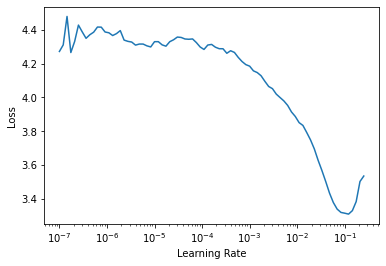

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
train_json   = 'annotations/instances_train2017.json'
valid_json   = 'annotations/instances_val2017.json'
train_im_dir = 'train2017'
valid_im_dir = 'val2017'


### Get files and annos ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]


### Get largest anno ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)
# get_xyz helpers (used in following sections)
files2lbl  = {f:l for f,l in zip(files,largest_lbl)}
files2bbox = {f:b for f,b in zip(files,largest_bbox)}
def get_lbl(f):  return files2lbl[f]
def get_bbox(f): return files2bbox[f]


### Get singles ###
# identify singles
lbls_per_im = L(len(l) for l in lbls)
tuples = L(zip(files, largest_lbl, largest_bbox))
singles = tuples[lbls_per_im.map(lambda n:n==1)]
singles_tp = transpose(singles)
# identify lbls with at least 500 singles
lbl2paths = {l:[p for p in singles_tp[0] if get_lbl(p) == l] 
             for l in set(singles_tp[1])}
lbl_subset=[]
for lbl in lbl2paths:
    l = len(lbl2paths[lbl])
    if l > 500: lbl_subset += [lbl]
# create subset of ims in lbl_subset
subset = L(s for s in singles if s[1] in lbl_subset)
files_subset = L(i[0] for i in subset)


### Datasets & DataLoaders ###
# dss
dss_tfms = [[PILImage.create], [get_bbox, TensorBBox.create]]
splits = RandomSplitter(.15)(files_subset)
dss = Datasets(files_subset, tfms=dss_tfms, splits=splits)
# dls
cpu_tfms = [PointScaler(), Resize(im_size, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)


### Model & Train ###
learn = cnn_learner(dls, resnet34, loss_func=MSELossFlat())
lr_min, _ = learn.lr_find()
learn.fit_one_cycle(10, lr=lr_min) # valid_loss of .0786 after 9 epochs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


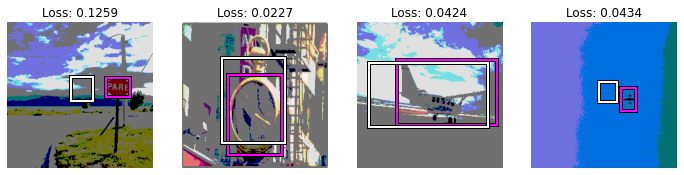

In [ ]:
### Showing results ###
def _descale(x,sz): return (x+1)*sz//2
def show_learner_results(learner, n=4, nrows=1, ncols=4, sz=224):
    xb, yb = learner.dls.one_batch()
    yp = learner.model(xb) # this is GPU hungry; need to get inference on one item
    xb, yb, yp = xb.cpu(), yb.cpu(), yp.cpu()
    
    ctxs = get_grid(n, nrows, ncols)
    for i,ctx in enumerate(ctxs):
        im, actual, forecast  = xb[i], yb[i], yp[i]
        loss = learner.loss_func(actual, forecast).item()
        
        im = F.relu(_descale(im.int(),sz))
        actual = TensorBBox(_descale(actual,sz))
        forecast = TensorBBox(_descale(forecast,sz))

        show_image(im, ctx=ctx, title=f'Loss: {round(loss,4)}')
        actual.show(ctx=ctx, color='magenta')
        forecast.show(ctx=ctx)
show_learner_results(learn)